In [1]:
from re import A, S
import tensorflow as tf

import math
import pandas as pd

from tensorflow.python.ops.gen_control_flow_ops import no_op
from GAE.utils import gen_f0_from_tensors,FramsManager
from FramsticksLib import *
from scipy.spatial import distance
from scipy.stats import spearmanr
from enum import Enum
import spektral.data as data
from GAE.LossManager import LossManager
from GAE.GraphDataset import GraphDataset
import matplotlib.pyplot as plt

class LossTypes(Enum):
    joints = "joints"
    parts = "parts"
    fitness = "fitness"
    dissim = "dissim"
    No = "None"
    def __str__(self):
        return self.name


ModuleNotFoundError: No module named 'utils'

In [ ]:
pathframs = "/home/adam/Framsticks/Framsticks50rc19"
path_sim ="/home/adam/thesis/VGAE/framspy/eval-allcriteria.sim"
pathdata ="graphs/gen/"


In [12]:
train, test = GraphDataset(pathframs, pathdata,size_of_adj=15,train_size=0.8).read()


Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

[Errno 2] No such file or directory: 'graphs/gen/142-checkpoint.gen'
pass
[Errno 2] No such file or directory: 'graphs/gen/57-checkpoint.gen'
pass
[Errno 2] No such file or directory: 'graphs/gen/0-checkpoint.gen'
pass
[Errno 2] No such file or directory: 'graphs/gen/145-checkpoint.gen'
pass
[Errno 2] No such file or directory: 'graphs/gen/250-checkpoint.gen'
pass
[Errno 2] No such file or directory: 'graphs/gen/195-checkpoint.gen'
pass


In [16]:
# vertpos, number of parts, number of joints, 

In [14]:
len(train)

21695

In [44]:
train

GraphData(n_graphs=21695)

In [15]:
len(test)

5424

lossManager = LossManager(pathframs,path_sim,"vertpos")

In [39]:
lossManager = LossManager(pathframs,path_sim,"vertpos")

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Using Framsticks version: 5.0rc19.1
Home (writable) dir     : /home/adam/Framsticks/Framsticks50rc19/data
Resources dir           : /home/adam/Framsticks/Framsticks50rc19/data

Available objects: ['CheckpointEvent', 'Collision', 'CrCollision', 'Creature', 'CreatureSettings', 'CreatureSignals', 'CreatureSnapshot', 'Dictionary', 'ExpProperties', 'ExpState', 'ExtValue', 'File', 'FunctionReference', 'GenMan', 'GenManStats', 'GenePool', 'GenePools', 'Geno', 'Genotype', 'Interface', 'Joint', 'Loader', 'Math', 'MechJoint', 'MechPart', 'MessageCatcher', 'Model', 'ModelGeometry', 'ModelSymmetry', 'Neuro', 'NeuroClass', 'NeuroClassLibrary', 'NeuroDef', 'NeuroSignals', 'NeuronsSimEnabled', 'ODE', 'Orient', 'Part', 'Population', 'Populations', 'Ref', 'Signal', 'SignalView', 'SimilMeasure', 'SimilMeasureDistribution', 'Simil

In [63]:
end = False
c = 500

# vertpos, number of parts, number of joints
columns = ["vertpos","n_parts","n_joints"]
all_data= pd.DataFrame(columns=columns)

itTrain = math.ceil(len(train)/c)
itTest = math.ceil(len(test)/c)
# print(it)
# data_model = [[vertpos,n_parts,n_joints]]
# data_model = pd.DataFrame(data_model,columns=columns) 
for i in range(itTrain):
    data = train[i*c:(i+1)*c]
    a_arr = []
    x_arr = []
    for g in data:
        a_arr.append(g.a)
        x_arr.append(g.x)
    d =[(tf.convert_to_tensor(x_arr)), tf.convert_to_tensor(a_arr)]
    x,a= d
    gen_list = gen_f0_from_tensors(x,a)
    ev= lossManager.framsLib.evaluate(gen_list)
    temp_list = []
    for e in ev:
        temp_list.append([e['evaluations']['']['vertpos'],e['evaluations']['']['numparts'],e['evaluations']['']['numjoints']])
#     print(ev[0]['evaluations'][''])
    part_data = pd.DataFrame(temp_list,columns=columns) 
    all_data = all_data.append(part_data, ignore_index=True)

for i in range(itTest):
    data = test[i*c:(i+1)*c]
    a_arr = []
    x_arr = []
    for g in data:
        a_arr.append(g.a)
        x_arr.append(g.x)
    d =[(tf.convert_to_tensor(x_arr)), tf.convert_to_tensor(a_arr)]
    x,a= d
    gen_list = gen_f0_from_tensors(x,a)
    ev= lossManager.framsLib.evaluate(gen_list)
    temp_list = []
    for e in ev:
        temp_list.append([e['evaluations']['']['vertpos'],e['evaluations']['']['numparts'],e['evaluations']['']['numjoints']])
#     print(ev[0]['evaluations'][''])
    part_data = pd.DataFrame(temp_list,columns=columns) 
    all_data = all_data.append(part_data, ignore_index=True)
#     break
all_data

KeyboardInterrupt: 

In [62]:
# all_data.to_csv('all_data.csv',index=None)

In [64]:
all_data = pd.read_csv("all_data.csv")

In [95]:
all_data.describe()

,vertpos,n_parts,n_joints
count,27119.000000,27119.000000,27119.000000
mean,0.049078,7.181976,7.816807
std,0.107883,3.595919,6.201249
min,-0.049551,2.000000,1.000000
25%,-0.015000,4.000000,3.000000
50%,0.004503,6.000000,6.000000
75%,0.068423,10.000000,11.000000
max,1.135704,15.000000,30.000000


In [82]:
n_parts = all_data['n_parts'].value_counts().to_dict()

/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


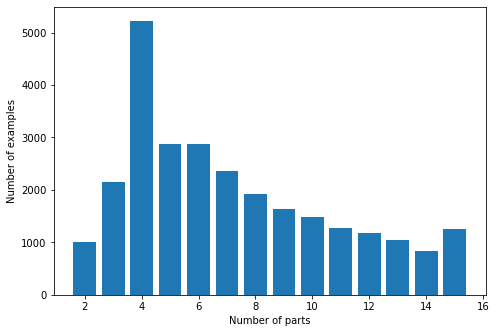

In [98]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_parts.keys(),n_parts.values())
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of parts')
plt.tight_layout()
plt.savefig("npartsData.pdf", bbox_inches = "tight")
plt.show()


In [99]:
n_joints  = all_data['n_joints'].value_counts().to_dict()

/home/adam/anaconda/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


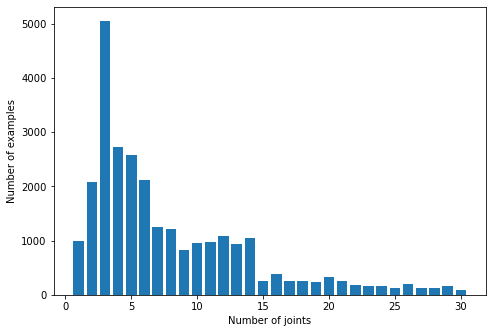

In [100]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_joints.keys(),n_joints.values())
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of joints')
plt.tight_layout()
plt.savefig("njointsData.pdf", bbox_inches = "tight")
plt.show()


In [56]:
# end = False
# c = 0
# while not end:
#     x,a = next(loader_train)
#     d =[(tf.convert_to_tensor(x)), tf.convert_to_tensor(a)]
#     x,a= d
#     gen_list = gen_f0_from_tensors(x,a)
#     ev= lossManager.framsLib.evaluate(gen_list)
#     l = len(ev)
#     for j in range(l):
#         try:
#             fit =  ev[j]['evaluations']['']['vertpos']
#         except:
#             print(ev[j])
#             print(gen_list[j])
# #     if "False" in ev:
# #         ind = ev.index("False")
# #         print(gen_list[ind])
# #         end = True
#     c +=1
#     if c >1000:
#         end = True

In [57]:
# end = False
# c = 0
# while not end:
#     x,a = next(loader_test)
#     d =[(tf.convert_to_tensor(x)), tf.convert_to_tensor(a)]
#     x,a= d
#     gen_list = gen_f0_from_tensors(x,a)
#     ev= lossManager.framsLib.evaluate(gen_list)
#     l = len(ev)
#     for j in range(l):
#         try:
#             fit =  ev[j]['evaluations']['']['vertpos']
#         except:
#             print(ev[j])
#             print(gen_list[j])
# #     if "False" in ev:
# #         ind = ev.index("False")
# #         print(gen_list[ind])
# #         end = True
#     c +=1
#     if c >500:
#         end = True

In [10]:
p = "//0\np:1.31, 1.16, 1.21\np:2.77, 0.0, 1.93\np:2.77, 0.0, 1.93\nj:0, 1\nj:0, 2\nj:1, 2\n"
print("isValid:",lossManager.framsLib.isValid([p]))
print("evaluate",lossManager.framsLib.evaluate([p]))

print("genotype:\n",p)

isValid: [True]
evaluate [{'num': 3, 'name': 'Otuzan Hih', 'evaluations': None}]
genotype:
 //0
p:1.31, 1.16, 1.21
p:2.77, 0.0, 1.93
p:2.77, 0.0, 1.93
j:0, 1
j:0, 2
j:1, 2



In [75]:
gen_list[11]

'//0\np:1.19, 1.3, 1.25\np:1.27, 1.11, 1.1\np:1.1, 1.48, 0.87\np:1.22, 1.37, 0.6\np:1.13, 1.3, 0.78\np:1.24, 1.8, 0.81\np:2.45, 0.11, 0.52\np:2.37, 0.0, 0.84\np:1.82, 0.26, 0.01\np:2.09, 1.91, 0.85\nj:0, 5\nj:0, 9\nj:1, 4\nj:1, 7\nj:1, 9\nj:2, 5\nj:2, 9\nj:3, 6\nj:3, 7\nj:3, 8\nj:3, 9\nj:4, 5\nj:4, 9\nj:5, 9\nj:6, 8\nj:7, 9\nj:8, 9\n'

In [73]:
gen_list[10]

'//0\np:1.0, 0.0, 0.0\np:2.23, 0.42, 0.0\np:3.23, 2.09, 0.0\np:4.01, 3.35, 0.02\nj:0, 1\nj:1, 2\nj:2, 3\nj:3, 4\n'

In [74]:
print(gen_list[10])

//0
p:1.0, 0.0, 0.0
p:2.23, 0.42, 0.0
p:3.23, 2.09, 0.0
p:4.01, 3.35, 0.02
j:0, 1
j:1, 2
j:2, 3
j:3, 4



In [78]:
lossManager.framsLib.isValid(gen_list)

[False]

In [79]:
print(x[0])
print(a[0])

tf.Tensor(
[[ 0.    0.    0.  ]
 [ 1.3   0.    0.  ]
 [ 2.45  0.    0.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]
 [-1.   -1.   -1.  ]], shape=(15, 3), dtype=float64)
tf.Tensor(
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

In [76]:
gen_list[0]

'//0\np:1.3, 0.0, 0.0\np:2.45, 0.0, 0.0\nj:0, 1\nj:1, 2\n'

In [77]:
print(gen_list[0])

//0
p:1.3, 0.0, 0.0
p:2.45, 0.0, 0.0
j:0, 1
j:1, 2



In [ ]:
gen_list[0]

In [63]:
for i in range(len(c)):
    if c[i]['evaluations']==None:
        print(i)

0
2
10
31
33
41
48
90
93
94


In [66]:
print(gen_list[31])

//0
p:1.3, 0.0, 0.0
p:2.39, 0.37, 0.0
j:0, 1
j:1, 2



In [67]:
print(gen_list[32])

//0
p:0.06, 0.25, 0.01
p:1.07, 0.07, 0.07
p:1.21, 0.28, 0.0
j:0, 1
j:0, 2



In [ ]:
c = self.framsLib.evaluate(gen_list)
for g in gen_list:
    print(g)
fit_list = [f['evaluations'][''][self.fitness] for f in c]
dist_list = self.get_latent_dist(latent_space)
rho, p = spearmanr(fit_list, dist_list)